In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

Data

In [2]:
# Load the data
data = pd.read_csv('MWG.csv', parse_dates=['Date'])

# Convert 'Price' column to numeric
data['Price'] = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce')

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Sort the index
data.sort_index(inplace=True)

# Set the frequency of the index
data = data.asfreq('B')

# Fill missing values if any (forward fill)
data['Price'].fillna(method='ffill', inplace=True)

# Split the data into training and testing sets
train_data = data[:'2022-02-28']
test_data = data['2022-03-01':'2023-03-31']

train = train_data['Price'].values
test = test_data['Price'].values

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))
model_path = "GRU_mwg.h5"

C:\Users\minht\AppData\Local\Temp\ipykernel_10140\1534482072.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Price'].fillna(method='ffill', inplace=True)


In [3]:
train_data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-01-02,31276.0,"31,039","31,394","31,039",2.27M,0.76%
2018-01-03,31892.0,"31,323","32,034","31,276",4.53M,1.97%
2018-01-04,31963.0,"31,773","32,081","31,750",2.71M,0.22%
2018-01-05,31608.0,"31,987","31,987","31,465",2.93M,-1.11%
2018-01-08,31110.0,"31,394","31,513","31,039",3.01M,-1.58%
...,...,...,...,...,...,...
2022-02-22,68405.0,"66,070","69,150","65,772",6.55M,2.84%
2022-02-23,68455.0,"68,405","69,846","68,008",3.22M,0.07%
2022-02-24,67958.0,"68,057","68,405","67,312",2.35M,-0.73%


In [4]:
train_scaled[0]

array([0.22860712])

In [5]:
train_scaled.shape

(1085, 1)

In [6]:
x_train, x_val = train_test_split(train_scaled, test_size=0.2, shuffle=False)
x_train.shape

(868, 1)

In [7]:
x_train[0]

array([0.22860712])

In [8]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 20
train_generator = TimeseriesGenerator(x_train, x_train, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(x_val, x_val, length=n_input, batch_size=1)
train_generator[0]

(array([[[0.22860712],
         [0.2402665 ],
         [0.24161036],
         [0.23489107],
         [0.22546514],
         [0.22635474],
         [0.2317491 ],
         [0.22815286],
         [0.22052505],
         [0.22186891],
         [0.22366703],
         [0.21066379],
         [0.217402  ],
         [0.20843034],
         [0.21291617],
         [0.21291617],
         [0.21291617],
         [0.21514962],
         [0.20708648],
         [0.19183086]]]),
 array([[0.20125679]]))

Model

In [9]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(n_input, 1)))
model.add(Dense(1))  
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_weights_only=False,
    save_best_only=True,
    verbose=1
)

In [11]:
history = model.fit(train_generator, validation_data=val_generator, batch_size=16, epochs=30, callbacks=[checkpoint_callback, reduce_lr])

Epoch 1/30
844/848 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 1: val_loss improved from inf to 0.00255, saving model to GRU_mwg.h5
848/848 [==============================] - 7s 6ms/step - loss: 0.0011 - val_loss: 0.0025 - lr: 0.0100
Epoch 2/30
 21/848 [..............................] - ETA: 4s - loss: 5.8526e-04

d:\Python\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


846/848 [============================>.] - ETA: 0s - loss: 5.1498e-04
Epoch 2: val_loss did not improve from 0.00255
848/848 [==============================] - 5s 6ms/step - loss: 5.1660e-04 - val_loss: 0.0026 - lr: 0.0100
Epoch 3/30
847/848 [============================>.] - ETA: 0s - loss: 4.0518e-04
Epoch 3: val_loss improved from 0.00255 to 0.00070, saving model to GRU_mwg.h5
848/848 [==============================] - 5s 6ms/step - loss: 4.0494e-04 - val_loss: 7.0305e-04 - lr: 0.0100
Epoch 4/30
846/848 [============================>.] - ETA: 0s - loss: 3.3527e-04
Epoch 4: val_loss did not improve from 0.00070
848/848 [==============================] - 5s 6ms/step - loss: 3.3481e-04 - val_loss: 0.0038 - lr: 0.0100
Epoch 5/30
845/848 [============================>.] - ETA: 0s - loss: 3.4246e-04
Epoch 5: val_loss did not improve from 0.00070
848/848 [==============================] - 5s 6ms/step - loss: 3.4175e-04 - val_loss: 7.2588e-04 - lr: 0.0100
Epoch 6/30
848/848 [===============

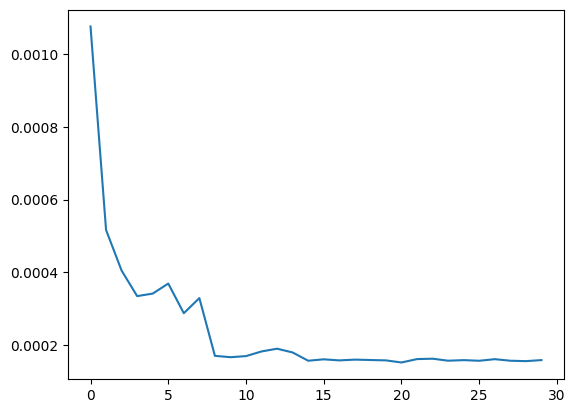

In [12]:
loss = model.history.history['loss']
plt.plot(range(len(loss)), loss)

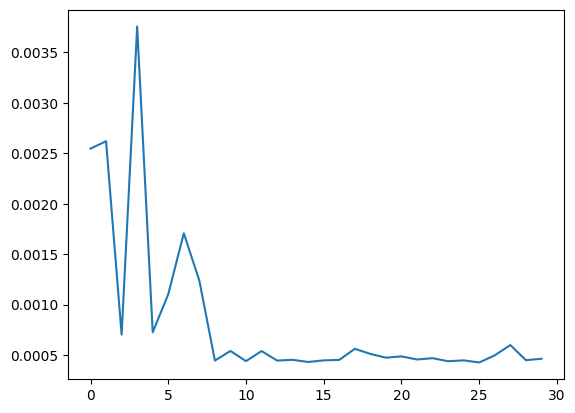

In [13]:
val_loss = model.history.history['val_loss']
plt.plot(range(len(val_loss)), val_loss)

Evaluation

In [3]:
model = tf.keras.models.load_model(model_path)

In [15]:
y_pred = model.predict(train_scaled)

34/34 [==============================] - 0s 1ms/step


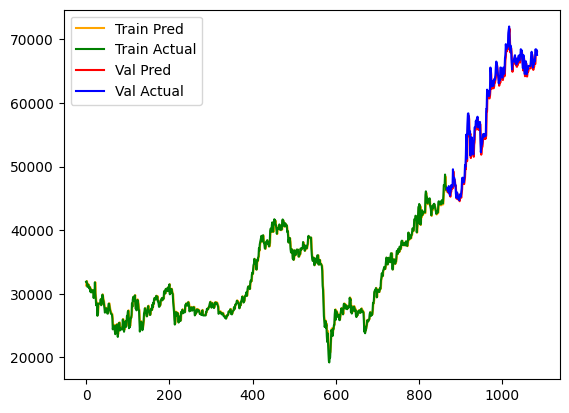

In [16]:
y_pred = scaler.inverse_transform(y_pred)
x_train = scaler.inverse_transform(x_train)
x_val = scaler.inverse_transform(x_val)
plt.plot(range(len(x_train)-1), y_pred[:len(x_train)-1], color ="orange", label = "Train Pred")
plt.plot(range(len(x_train)-1), x_train[1:], color ="green", label = "Train Actual")
plt.plot(range(len(x_train)-1,len(train_scaled)-1), y_pred[len(x_train)-1:-1], color ="red", label = "Val Pred")
plt.plot(range(len(x_train)-1,len(train_scaled)-1), x_val, color ="blue", label = "Val Actual")
plt.legend()

In [4]:
data_scaled = np.concatenate((train_scaled, test_scaled))
pred = model.predict(data_scaled)
pred = pred[-len(test_scaled)-1:-1]

43/43 [==============================] - 0s 1ms/step


In [18]:
len(pred)

284

In [5]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

plot_pred = scaler.inverse_transform(pred)
actual = scaler.inverse_transform(test_scaled)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


r2 = r2_score(test_scaled, pred)
print("R-squared:", r2)
mape = mean_absolute_percentage_error(actual, plot_pred)
print("MAPE:", mape)
rmse = math.sqrt(mean_squared_error(actual, plot_pred))
print("RMSE:", rmse)


R-squared: 0.9854582981162439
MAPE: 1.9784996605462388
RMSE: 1596.5088030953464


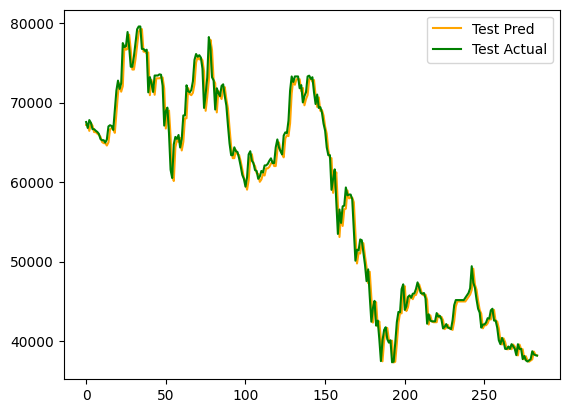

In [22]:
plt.plot(range(len(actual)), plot_pred, color ="orange", label = "Test Pred")
plt.plot(range(len(actual)), actual, color ="green", label = "Test Actual")
plt.legend()